<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/busca-competitiva/busca_competitiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

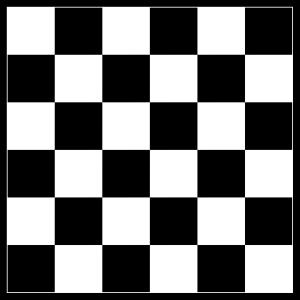

In [2]:
from __future__ import annotations
from typing import List, Tuple
from IPython.display import clear_output 
from copy import deepcopy
import numpy as np
import pandas as pd

In [3]:
class Piece:
    def __init__(self, row: int, col: int, owner: str) -> None:
        self.queen = False
        self.row = row
        self.col = col
        self.owner = owner

    def make_queen(self) -> None:
        self.queen = True

    def move(self, row, col):
        self.row = row
        self.col = col

    def __repr__(self):
        return self.owner.lower() if self.queen == False else self.owner

In [4]:
class Board:
    
    def __init__(self, state: np.ndarray = None) -> None:
        self.player_left = self.ai_left = 6
        self.player_queens = self.ai_queens = 0
        self.player_pieces = []
        self.ai_pieces = []
        self.state = self.setup_game() if state == None else state
        self.winner = None

    def setup_game(self):
        state = []
        for row in range(6):
            state.append([])
            for col in range(6):
                if col % 2 == ((row +  1) % 2):
                    if row < 2:
                        piece = Piece(row, col, 'A')
                        state[row].append(piece)
                        self.ai_pieces.append(piece)
                    elif row > 3:
                        piece = Piece(row, col, 'P')
                        state[row].append(piece)
                        self.player_pieces.append(piece)
                    else:
                        state[row].append(' ')
                else:
                    state[row].append(' ')
        return np.array(state)

    def get_all_pieces(self, owner: str) -> List[Piece]:
        pieces = []
        for row in self.state:
            for piece in row:
                if piece != ' ' and piece.owner == owner:
                    pieces.append(piece)
        return pieces

    def remove(self, pieces: List[Piece]) -> None:
        for piece in pieces:
            self.state[piece.row][piece.col] = ' '
            if piece != ' ':
                if piece.owner == 'P':
                    # self.player_pieces.remove(piece)
                    self.player_left -= 1
                else:
                    # self.ai_pieces.remove(piece)
                    self.ai_left -= 1

    def move(self, piece: Piece, row: int, col: int) -> None:
        if not type(piece) == str:
            self.state[piece.row][piece.col], self.state[row][col] = self.state[row][col], self.state[piece.row][piece.col]
            piece.move(row, col)

            if row == 5 or row == 0:
                piece.make_queen()
                if piece.owner == 'P':
                    self.player_queens += 1
                else:
                    self.ai_queens += 1 

    def get_piece(self, row, col):
        return self.state[row][col]

    def get_valid_moves(self, piece):
        moves = {}
        left = piece.col - 1
        right = piece.col + 1
        row = piece.row

        if piece.owner == 'P' or piece.queen:
            moves.update(self._traverse_left(row -1, max(row-3, -1), -1, piece.owner, left))
            moves.update(self._traverse_right(row -1, max(row-3, -1), -1, piece.owner, right))
        if piece.owner == 'A' or piece.queen:
            moves.update(self._traverse_left(row +1, min(row+3, 6), 1, piece.owner, left))
            moves.update(self._traverse_right(row +1, min(row+3, 6), 1, piece.owner, right))
    
        return moves

    def _traverse_left(self, start, stop, step, owner, left, skipped=[]):
        moves = {}
        last = []
        for r in range(start, stop, step):
            if left < 0:
                break
            
            current = self.state[r][left]
            if current == ' ':
                if skipped and not last:
                    break
                elif skipped:
                    moves[(r, left)] = last + skipped
                else:
                    moves[(r, left)] = last
                
                if last:
                    if step == -1:
                        row = max(r-3, 0)
                    else:
                        row = min(r+3, 6)
                    moves.update(self._traverse_left(r+step, row, step, owner, left-1,skipped=last))
                    moves.update(self._traverse_right(r+step, row, step, owner, left+1,skipped=last))
                break
            elif current.owner == owner:
                break
            else:
                last = [current]

            left -= 1
        
        return moves

    def _traverse_right(self, start, stop, step, owner, right, skipped=[]):
        moves = {}
        last = []
        for r in range(start, stop, step):
            if right >= 6:
                break
            
            current = self.state[r][right]
            if current == ' ':
                if skipped and not last:
                    break
                elif skipped:
                    moves[(r,right)] = last + skipped
                else:
                    moves[(r, right)] = last
                
                if last:
                    if step == -1:
                        row = max(r-3, 0)
                    else:
                        row = min(r+3, 6)
                    moves.update(self._traverse_left(r+step, row, step, owner, right-1,skipped=last))
                    moves.update(self._traverse_right(r+step, row, step, owner, right+1,skipped=last))
                break
            elif current.owner == owner:
                break
            else:
                last = [current]

            right += 1
        
        return moves

    def evaluate(self):
        return self.ai_left - self.player_left + (self.ai_queens * 0.5 - self.player_queens * 0.5)

    def __repr__(self) -> str:
        return '\n' + str(pd.DataFrame(self.state)) + '\n'


In [5]:
class Checkers:

    def __init__(self, state = None) -> None:
        self.board = Board(state)
        self.turn = 'P'
        self.selected = None

    def select(self, row = None, col = None):
        if self.turn == 'P':
            i = 1
            for piece in self.board.player_pieces:
                if self.board.get_valid_moves(piece):
                    print(f'{i}-({piece.row}, {piece.col}) ', end='')
                    i += 1
            choice = int(input('Qual peça será jogada? '))
            # clear_output()
            print(self.board)
            row = self.board.player_pieces[choice - 1].row
            col = self.board.player_pieces[choice - 1].col
            self.valid_moves = self.board.get_valid_moves(self.board.get_piece(row, col))
            i = 1
            dict_moves = {}
            for key, value in self.valid_moves.items():
                dict_moves[i] = key
                print(f'{i}-({key} = {value}) ', end='')
                i += 1
            choice = int(input('Qual será o movimento? '))
            coord = dict_moves[choice]
            self.selected = self.board.get_piece(row, col)
            self.move(coord[0], coord[1])
            return

        self.selected = self.board.get_piece(row, col)
        self.valid_moves = self.board.get_valid_moves(self.selected)
        return


    def move(self, row, col):
        piece = self.board.get_piece(row, col)
        if self.selected and piece == ' ' and (row, col) in self.valid_moves:
            self.board.move(self.selected, row, col)
            skipped = self.valid_moves[(row, col)]
            if skipped:
                self.board.remove(skipped)

        return

    def get_board(self):
        return self.board

    def change_turn(self):
        if self.turn == 'P':
            self.turn = 'A'
        else:
            self.turn = 'P'

    def winner(self):
        return self.board.winner

    def ai_move(self, board):
        self.board = board
        self.change_turn()

In [6]:
def minimax(board, depth, max_player, checkers):
    if depth == 0 or checkers.winner() != None:
        return board.evaluate(), board
    
    if max_player:
        maxEval = float('-inf')
        best_move = None
        for move in get_all_moves(board, 'A', checkers):
            evaluation = minimax(move, depth-1, False, checkers)[0]
            maxEval = max(maxEval, evaluation)
            if maxEval == evaluation:
                best_move = move
        
        return maxEval, best_move
    else:
        minEval = float('inf')
        best_move = None
        for move in get_all_moves(board, 'P', checkers):
            evaluation = minimax(move, depth-1, True, checkers)[0]
            minEval = min(minEval, evaluation)
            if minEval == evaluation:
                best_move = move
        
        return minEval, best_move


def simulate_move(piece, move, board, checkers, skip):
    board.move(piece, move[0], move[1])
    if skip:
        board.remove(skip)

    return board


def get_all_moves(board, owner, checkers):
    moves = []

    for piece in board.get_all_pieces(owner):
        valid_moves = board.get_valid_moves(piece)
        for move, skip in valid_moves.items():
            temp_board = deepcopy(board)
            temp_piece = temp_board.get_piece(piece.row, piece.col)
            if type(temp_piece) == str:
                print(temp_piece, 3)
            new_board = simulate_move(temp_piece, move, temp_board, checkers, skip)
            moves.append(new_board)
    
    return moves


In [7]:
def game():
    checkers = Checkers()

    while True:
        
        # clear_output()
        
        
        if checkers.turn == 'A':
            value, new_board = minimax(checkers.get_board(), 4, 'A', checkers)
            checkers.ai_move(new_board)
        
        print(checkers.board)

        if checkers.winner() != None:
            print(checkers.winner())
            break

        checkers.select()
        checkers.change_turn()
  

In [8]:
game()


   0  1  2  3  4  5
0     a     a     a
1  a     a     a   
2                  
3                  
4     p     p     p
5  p     p     p   

1-(4, 1) 2-(4, 3) 3-(4, 5) Qual peça será jogada? 1

   0  1  2  3  4  5
0     a     a     a
1  a     a     a   
2                  
3                  
4     p     p     p
5  p     p     p   

1-((3, 0) = []) 2-((3, 2) = []) Qual será o movimento? 1

   0  1  2  3  4  5
0     a     a     a
1  a     a         
2                 a
3  p               
4           p     p
5  p     p     p   

1-(3, 0) 2-(4, 3) 3-(4, 5) 4-(5, 0) 5-(5, 2) Qual peça será jogada? 2

   0  1  2  3  4  5
0     a     a     a
1  a     a         
2                 a
3  p               
4           p     p
5  p     p     p   

1-((3, 2) = []) 2-((3, 4) = []) Qual será o movimento? 1

   0  1  2  3  4  5
0     a     a     a
1  a               
2           a     a
3  p     p         
4                 p
5  p     p     p   

1-(3, 0) 2-(3, 2) 3-(4, 5) 4-(5, 0) 5-(5, 2) 6-(5, 4) 

AttributeError: ignored